# **Project: Amazon Product Recommendation System**

# **Marks: 40**


Welcome to the project on Recommendation Systems. We will work with the Amazon product reviews dataset for this project. The dataset contains ratings of different electronic products. It does not include information about the products or reviews to avoid bias while building the model. 

--------------
## **Context:**
--------------

Today, information is growing exponentially with volume, velocity and variety throughout the globe. This has lead to information overload, and too many choices for the consumer of any business. It represents a real dilemma for these consumers and they often turn to denial. Recommender Systems are one of the best tools that help recommending products to consumers while they are browsing online. Providing personalized recommendations which is most relevant for the user is what's most likely to keep them engaged and help business. 

E-commerce websites like Amazon, Walmart, Target and Etsy use different recommendation models to provide personalized suggestions to different users. These companies spend millions of dollars to come up with algorithmic techniques that can provide personalized recommendations to their users.

Amazon, for example, is well-known for its accurate selection of recommendations in its online site. Amazon's recommendation system is capable of intelligently analyzing and predicting customers' shopping preferences in order to offer them a list of recommended products. Amazon's recommendation algorithm is therefore a key element in using AI to improve the personalization of its website. For example, one of the baseline recommendation models that Amazon uses is item-to-item collaborative filtering, which scales to massive data sets and produces high-quality recommendations in real-time.

----------------
## **Objective:**
----------------

You are a Data Science Manager at Amazon, and have been given the task of building a recommendation system to recommend products to customers based on their previous ratings for other products. You have a collection of labeled data of Amazon reviews of products. The goal is to extract meaningful insights from the data and build a recommendation system that helps in recommending products to online consumers.

-----------------------------
## **Dataset:** 
-----------------------------

The Amazon dataset contains the following attributes:

- **userId:** Every user identified with a unique id
- **productId:** Every product identified with a unique id
- **Rating:** The rating of the corresponding product by the corresponding user
- **timestamp:** Time of the rating. We **will not use this column** to solve the current problem

**Note:** The code has some user defined functions that will be usefull while making recommendations and measure model performance, you can use these functions or can create your own functions. 

Sometimes, the installation of the surprise library, which is used to build recommendation systems, faces issues in Jupyter. To avoid any issues, it is advised to use **Google Colab** for this project.

Let's start by mounting the Google drive on Colab.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

**Installing surprise library**

In [ ]:
!pip install surprise

## **Importing the necessary libraries and overview of the dataset**

In [5]:
# Used to ignore the warning given as output of the code
import warnings
warnings.filterwarnings('ignore')

# Basic libraries of python for numeric and dataframe computations
import numpy as np, pandas as pd

# Basic library for data visualization
import matplotlib.pyplot as plt

# Slightly advanced library for data visualization
import seaborn as sns

# A dictionary output that does not raise a key error
from collections import defaultdict

# A performance metrics in sklearn
from sklearn.metrics import mean_squared_error

### **Loading the data**
- Import the Dataset
- Add column names ['user_id', 'prod_id', 'rating', 'timestamp']
- Drop the column timestamp
- Copy the data to another DataFrame called **df**

In [843]:
ratings_df = pd.read_csv('ratings_Electronics.csv', header=None, names=['user_id', 'prod_id', 'rating', 'timestamp'])

In [845]:
df = ratings_df.drop('timestamp', axis=1)
df.head()

,user_id,prod_id,rating
0,AKM1MP6P0OYPR,0132793040,5.0
1,A2CX7LUOHB2NDG,0321732944,5.0
2,A2NWSAGRHCP8N5,0439886341,1.0
3,A2WNBOD3WNDNKT,0439886341,3.0
4,A1GI0U4ZRJA8WN,0439886341,1.0


In [847]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7824482 entries, 0 to 7824481
Data columns (total 3 columns):
 #   Column   Dtype  
---  ------   -----  
 0   user_id  object 
 1   prod_id  object 
 2   rating   float64
dtypes: float64(1), object(2)
memory usage: 179.1+ MB


**As this dataset is very large and has 7,824,482 observations, it is not computationally possible to build a model using this. Moreover, many users have only rated a few products and also some products are rated by very few users. Hence, we can reduce the dataset by considering certain logical assumptions.**

Here, we will be taking users who have given at least 50 ratings, and the products that have at least 5 ratings, as when we shop online we prefer to have some number of ratings of a product. 

In [850]:
df['user_id'].nunique()

4201696

In [852]:
df['prod_id'].nunique()

476002

In [854]:
# Get the column containing the users
users = df.user_id

# Create a dictionary from users to their number of ratings
ratings_count = dict()

for user in users:

    # If we already have the user, just add 1 to their rating count
    if user in ratings_count:        
        ratings_count[user] += 1
  
    # Otherwise, set their rating count to 1
    else:
        ratings_count[user] = 1

In [856]:
# We want our users to have at least 50 ratings to be considered
RATINGS_CUTOFF = 50

remove_users = []

for user, num_ratings in ratings_count.items():
    if num_ratings < RATINGS_CUTOFF:
        remove_users.append(user)

df = df.loc[ ~ df.user_id.isin(remove_users)]

In [857]:
# Get the column containing the products
prods = df.prod_id

# Create a dictionary from products to their number of ratings
ratings_count = dict()

for prod in prods:
    
    # If we already have the product, just add 1 to its rating count
    if prod in ratings_count:
        ratings_count[prod] += 1
    
    # Otherwise, set their rating count to 1
    else:
        ratings_count[prod] = 1    

In [860]:
# We want our item to have at least 5 ratings to be considered
RATINGS_CUTOFF = 5

remove_users = []

for user, num_ratings in ratings_count.items():
    if num_ratings < RATINGS_CUTOFF:
        remove_users.append(user)

df_final = df.loc[~ df.prod_id.isin(remove_users)]

In [862]:
# Print a few rows of the imported dataset
df_final.head()

,user_id,prod_id,rating
1310,A3LDPF5FMB782Z,1400501466,5.0
1322,A1A5KUIIIHFF4U,1400501466,1.0
1335,A2XIOXRRYX0KZY,1400501466,3.0
1451,AW3LX47IHPFRL,1400501466,5.0
1456,A1E3OB6QMBKRYZ,1400501466,1.0


## **Exploratory Data Analysis**

### **Shape of the data**

### **Check the number of rows and columns and provide observations.**

In [867]:
# Check the number of rows and columns and provide observations
df_final.shape

(65290, 3)

**Write your observations here:**
After removing users with less than 50 ratings and items with less than 5 reviews, we have reduced the dataset to only 65,290 observations.

### **Data types**

In [871]:
# Check Data types and provide observations
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Index: 65290 entries, 1310 to 7824427
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   user_id  65290 non-null  object 
 1   prod_id  65290 non-null  object 
 2   rating   65290 non-null  float64
dtypes: float64(1), object(2)
memory usage: 2.0+ MB


**Write your observations here:**
With only 65,290 rows now, the total memory usage for the data frame is now reduced to 2MB, from the original 179MB.

### **Checking for missing values**

In [875]:
# Check for missing values present and provide observations
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Index: 65290 entries, 1310 to 7824427
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   user_id  65290 non-null  object 
 1   prod_id  65290 non-null  object 
 2   rating   65290 non-null  float64
dtypes: float64(1), object(2)
memory usage: 2.0+ MB


**Write your observations here:**
As indicated by the Non-Null Count column in the info() output, none of the columns have null values.

### **Summary Statistics**

In [879]:
# Summary statistics of 'rating' variable and provide observations
df_final.describe().T

,count,mean,std,min,25%,50%,75%,max
rating,65290.0,4.294808,0.988915,1.0,4.0,5.0,5.0,5.0


**Write your observations here:**
The mean of ratings is 4.2, and suggests a right skewed distribution, with majority of ratings above 4.

### **Checking the rating distribution**

<Axes: xlabel='rating', ylabel='count'>

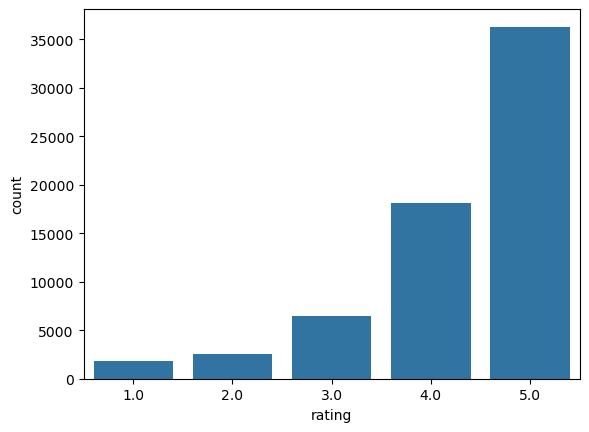

In [883]:
# Create the bar plot and provide observations
sns.countplot(x = "rating", data = df_final)

**Write your observations here:**
The bar plot confirms our conclusions from the stats above, showing 75% of the ratings between 4 and 5.

### **Checking the number of unique users and items in the dataset**

In [887]:
# Number of total rows in the data and number of unique user id and product id in the data
df_final['user_id'].nunique()

1540

In [889]:
df_final['prod_id'].nunique()

5689

**Write your observations here:**
There are 1540 unique users and 5689 unique items in the final dataset.

### **Users with the most number of ratings**

In [893]:
# Top 10 users based on the number of ratings
df_final['user_id'].value_counts().head(10)

user_id
ADLVFFE4VBT8      295
A3OXHLG6DIBRW8    230
A1ODOGXEYECQQ8    217
A36K2N527TXXJN    212
A25C2M3QF9G7OQ    203
A680RUE1FDO8B     196
A1UQBFCERIP7VJ    193
A22CW0ZHY3NJH8    193
AWPODHOB4GFWL     184
AGVWTYW0ULXHT     179
Name: count, dtype: int64

**Write your observations here:**
Above is provided the list of the top 10 users in number of ratings. The top most have provided 295, the tenth in the list had 179 reviews.

**Now that we have explored and prepared the data, let's build the first recommendation system.**

## **Model 1: Rank Based Recommendation System**

In [901]:
# Calculate the average rating for each product
avg = df_final.groupby('prod_id')['rating'].mean()

# Calculate the count of ratings for each product
count = df_final.groupby('prod_id')['rating'].count()
# Create a dataframe with calculated average and count of ratings
df_rating = pd.DataFrame({'rating_avg': avg, 'rating_count': count})

# Sort the dataframe by average of ratings in the descending order
df_rating.sort_values(by='rating_avg', ascending=False)

# See the first five records of the "final_rating" dataset
df_rating.head()

,rating_avg,rating_count
prod_id,,
1400501466,3.333333,6
1400532655,3.833333,6
1400599997,4.000000,5
9983891212,4.875000,8
B00000DM9W,5.000000,5


In [904]:
# Defining a function to get the top n products based on the highest average rating and minimum interactions
def find_top_popular(data, min, n):
# Finding products with minimum number of interactions
    filtered_df = data[data.rating_count > min]
# Sorting values with respect to average rating 
    return filtered_df.sort_values(by='rating_avg', ascending=False).head(n)

### **Recommending top 5 products with 50 minimum interactions based on popularity**

In [907]:
find_top_popular(df_rating, 50, 5)

,rating_avg,rating_count
prod_id,,
B001TH7GUU,4.871795,78
B003ES5ZUU,4.864130,184
B0019EHU8G,4.855556,90
B006W8U2MU,4.824561,57
B000QUUFRW,4.809524,84


### **Recommending top 5 products with 100 minimum interactions based on popularity**

In [910]:
find_top_popular(df_rating, 100, 5)

,rating_avg,rating_count
prod_id,,
B003ES5ZUU,4.864130,184
B000N99BBC,4.772455,167
B007WTAJTO,4.701220,164
B002V88HFE,4.698113,106
B004CLYEDC,4.669492,118


We have recommended the **top 5** products by using the popularity recommendation system. Now, let's build a recommendation system using **collaborative filtering.**

## **Model 2: Collaborative Filtering Recommendation System**

### **Building a baseline user-user similarity based recommendation system**

- Below, we are building **similarity-based recommendation systems** using `cosine` similarity and using **KNN to find similar users** which are the nearest neighbor to the given user.  
- We will be using a new library, called `surprise`, to build the remaining models. Let's first import the necessary classes and functions from this library.

In [916]:
# To compute the accuracy of models
from surprise import accuracy

# Class is used to parse a file containing ratings, data should be in structure - user ; item ; rating
from surprise.reader import Reader

# Class for loading datasets
from surprise.dataset import Dataset

# For tuning model hyperparameters
from surprise.model_selection import GridSearchCV

# For splitting the rating data in train and test datasets
from surprise.model_selection import train_test_split

# For implementing similarity-based recommendation system
from surprise.prediction_algorithms.knns import KNNBasic

# For implementing matrix factorization based recommendation system
from surprise.prediction_algorithms.matrix_factorization import SVD

# for implementing K-Fold cross-validation
from surprise.model_selection import KFold

# For implementing clustering-based recommendation system
from surprise import CoClustering

**Before building the recommendation systems, let's  go over some basic terminologies we are going to use:**

**Relevant item:** An item (product in this case) that is actually **rated higher than the threshold rating** is relevant, if the **actual rating is below the threshold then it is a non-relevant item**.  

**Recommended item:** An item that's **predicted rating is higher than the threshold is a recommended item**, if the **predicted rating is below the threshold then that product will not be recommended to the user**.  


**False Negative (FN):** It is the **frequency of relevant items that are not recommended to the user**. If the relevant items are not recommended to the user, then the user might not buy the product/item. This would result in the **loss of opportunity for the service provider**, which they would like to minimize.

**False Positive (FP):** It is the **frequency of recommended items that are actually not relevant**. In this case, the recommendation system is not doing a good job of finding and recommending the relevant items to the user. This would result in **loss of resources for the service provider**, which they would also like to minimize.

**Recall:** It is the **fraction of actually relevant items that are recommended to the user**, i.e., if out of 10 relevant products, 6 are recommended to the user then recall is 0.60. Higher the value of recall better is the model. It is one of the metrics to do the performance assessment of classification models.

**Precision:** It is the **fraction of recommended items that are relevant actually**, i.e., if out of 10 recommended items, 6 are found relevant by the user then precision is 0.60. The higher the value of precision better is the model. It is one of the metrics to do the performance assessment of classification models.

**While making a recommendation system, it becomes customary to look at the performance of the model. In terms of how many recommendations are relevant and vice-versa, below are some most used performance metrics used in the assessment of recommendation systems.**

### **Precision@k, Recall@ k, and F1-score@k**

**Precision@k** - It is the **fraction of recommended items that are relevant in `top k` predictions**. The value of k is the number of recommendations to be provided to the user. One can choose a variable number of recommendations to be given to a unique user.  


**Recall@k** - It is the **fraction of relevant items that are recommended to the user in `top k` predictions**.

**F1-score@k** - It is the **harmonic mean of Precision@k and Recall@k**. When **precision@k and recall@k both seem to be important** then it is useful to use this metric because it is representative of both of them. 

### **Some useful functions**

- Below function takes the **recommendation model** as input and gives the **precision@k, recall@k, and F1-score@k** for that model.  
- To compute **precision and recall**, **top k** predictions are taken under consideration for each user.
- We will use the precision and recall to compute the F1-score.

In [927]:
def precision_recall_at_k(model, model_name, k = 10, threshold = 3.5):
    """Return precision and recall at k metrics for each user"""

    # First map the predictions to each user
    user_est_true = defaultdict(list)
    
    # Making predictions on the test data
    predictions = model.test(testset)
    
    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():

        # Sort user ratings by estimated value
        user_ratings.sort(key = lambda x: x[0], reverse = True)

        # Number of relevant items
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

        # Number of recommended items in top k
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])

        # Number of relevant and recommended items in top k
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold))
                              for (est, true_r) in user_ratings[:k])

        # Precision@K: Proportion of recommended items that are relevant
        # When n_rec_k is 0, Precision is undefined. Therefore, we are setting Precision to 0 when n_rec_k is 0

        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0

        # Recall@K: Proportion of relevant items that are recommended
        # When n_rel is 0, Recall is undefined. Therefore, we are setting Recall to 0 when n_rel is 0

        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 0
    
    # Mean of all the predicted precisions are calculated.
    precision = round((sum(prec for prec in precisions.values()) / len(precisions)), 3)
    
    # Mean of all the predicted recalls are calculated.
    recall = round((sum(rec for rec in recalls.values()) / len(recalls)), 3)
    
    rmse = accuracy.rmse(predictions)

    f1 = round((2*precision*recall)/(precision+recall), 3)

    df_scores = pd.DataFrame(
        {
            "precision": precision,
            "recall": recall,
            "f1": f1,
            "RMSE": rmse,
        },
        index=[model_name],
    )
    return df_scores

**Hints:**

- To compute **precision and recall**, a **threshold of 3.5 and k value of 10 can be considered for the recommended and relevant ratings**.
- Think about the performance metric to choose.

Below we are loading the **`rating` dataset**, which is a **pandas DataFrame**, into a **different format called `surprise.dataset.DatasetAutoFolds`**, which is required by this library. To do this, we will be **using the classes `Reader` and `Dataset`.**

In [931]:
# Instantiating Reader scale with expected rating scale
reader = Reader(rating_scale = (0, 5))

# Loading the dataset
data = Dataset.load_from_df(df_final[['user_id', 'prod_id', 'rating']], reader)

# Splitting the data into train and test datasets
trainset, testset = train_test_split(data, test_size = 0.2, random_state = 42)

Now, we are **ready to build the first baseline similarity-based recommendation system** using the cosine similarity.

### **Building the user-user Similarity-based Recommendation System**

In [935]:
# Declaring the similarity options
sim_options = {'name': 'cosine', 'user_based': True}

# Initialize the KNNBasic model using sim_options declared, Verbose = False, and setting random_state = 1
uu_model = KNNBasic(sim_options = sim_options, verbose = False, random_state = 1)

# Fit the model on the training data
uu_model.fit(trainset)

# Let us compute precision@k, recall@k, and f_1 score using the precision_recall_at_k function defined above
computed_scores = precision_recall_at_k(uu_model, 'uu baseline')
computed_scores

RMSE: 1.0012


,precision,recall,f1,RMSE
uu baseline,0.855,0.858,0.856,1.001176


**Write your observations here:**
- The calculated RMSE gives an idea on how far the predicted rating is from the real ratings. It can be used as guide for comparing the different models and tunings.
- The precision is at 0.855, meaning that around 85% of our recommendations are relevant.
- The recall is at 0.854, meaning that we are able to recommend 85% of the relevant items.
- F1 score is a combination of precision and recall, and it's showing that the model is able to make relevant recommendations and recommend the most of the relevant items. 

Let's now **predict rating for a user with `userId=A3LDPF5FMB782Z` and `productId=1400501466`** as shown below. Here the user has already interacted or watched the product with productId '1400501466' and given a rating of 5.

In [939]:
# Predicting rating for a sample user with an interacted product
uu_model.predict("A3LDPF5FMB782Z", "1400501466", r_ui = 5, verbose = True)

user: A3LDPF5FMB782Z item: 1400501466 r_ui = 5.00   est = 3.40   {'actual_k': 5, 'was_impossible': False}


Prediction(uid='A3LDPF5FMB782Z', iid='1400501466', r_ui=5, est=3.4, details={'actual_k': 5, 'was_impossible': False})

**Write your observations here:**
The predicted rating (3.4) was much lower than the real rating (5). It seems this model is under-estimating the ratings.

Below is the **list of users who have not seen the product with product id "1400501466"**.

In [943]:
# Find unique user_id where prod_id is not equal to "1400501466"
df_final[df_final.prod_id != "1400501466"]['user_id']

2082       A2ZR3YTMEEIIZ4
2150       A3CLWR1UUZT6TG
2162        A5JLAU2ARJ0BO
2228       A1P4XD7IORSEFN
2363       A341HCMGNZCBIT
                ...      
7824423    A34BZM6S9L7QI4
7824424    A1G650TTTHEAL5
7824425    A25C2M3QF9G7OQ
7824426     A1E1LEVQ9VQNK
7824427    A2NYK9KWFMJV4Y
Name: user_id, Length: 65284, dtype: object

* It can be observed from the above list that **user "A34BZM6S9L7QI4" has not seen the product with productId "1400501466"** as this userId is a part of the above list.

**Below we are predicting rating for `userId=A34BZM6S9L7QI4` and `prod_id=1400501466`.** 

In [947]:
# Predicting rating for a sample user with a non interacted product
uu_model.predict("A34BZM6S9L7QI4", "1400501466", verbose = True)

user: A34BZM6S9L7QI4 item: 1400501466 r_ui = None   est = 4.29   {'was_impossible': True, 'reason': 'Not enough neighbors.'}


Prediction(uid='A34BZM6S9L7QI4', iid='1400501466', r_ui=None, est=4.292024046561495, details={'was_impossible': True, 'reason': 'Not enough neighbors.'})

**Write your observations here:**
The model failed to predict because it couldn't find similar users to the user with the given id, returning the global mean as an estimation.

### **Improving similarity-based recommendation system by tuning its hyperparameters**

Below, we will be tuning hyperparameters for the `KNNBasic` algorithm. Let's try to understand some of the hyperparameters of the KNNBasic algorithm:

- **k** (int) – The (max) number of neighbors to take into account for aggregation. Default is 40.
- **min_k** (int) – The minimum number of neighbors to take into account for aggregation. If there are not enough neighbors, the prediction is set to the global mean of all ratings. Default is 1.
- **sim_options** (dict) – A dictionary of options for the similarity measure. And there are four similarity measures available in surprise - 
    - cosine
    - msd (default)
    - Pearson
    - Pearson baseline

In [952]:
# Setting up parameter grid to tune the hyperparameters
params = {'k': [20, 30, 40], 'min_k': [1, 3, 6, 9, 12],
              'sim_options': {'name': ['msd', 'cosine', 'pearson', 'pearson_baseline'],
                              'user_based': [True]}
              }
# Performing 3-fold cross-validation to tune the hyperparameters
gs = GridSearchCV(KNNBasic, params, measures = ['rmse'], cv = 3, n_jobs = -1)

# Fitting the data
gs.fit(data)
# Best RMSE score
print(gs.best_score['rmse'])
# Combination of parameters that gave the best RMSE score
print(gs.best_params['rmse'])

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Done computing similarity matrix.
Computing the pearson_baseline similarity matrix...
Estimating biases using als...
Done computing similarity matrix.
Computing the pearson_baseline similarity matrix...
Estimating biases using als...
Done computing similarity matrix.
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Compu

Once the grid search is **complete**, we can get the **optimal values for each of those hyperparameters**.

Now, let's build the **final model by using tuned values of the hyperparameters**, which we received by using **grid search cross-validation**.

In [956]:
# Using the optimal similarity measure for user-user based collaborative filtering
sim_options = {'name': 'cosine', 'user_based': True}

# Creating an instance of KNNBasic with optimal hyperparameter values
uu_model_best = KNNBasic(sim_options = sim_options, k=40, min_k=6, verbose = False, random_state = 1)

# Training the algorithm on the trainset
uu_model_best.fit(trainset)
# Let us compute precision@k and recall@k also with k =10
computed_scores = pd.concat([computed_scores, precision_recall_at_k(uu_model_best, 'uu best')])
computed_scores

RMSE: 0.9526


,precision,recall,f1,RMSE
uu baseline,0.855,0.858,0.856,1.001176
uu best,0.847,0.894,0.870,0.952591


**Write your observations here:**
- The tuned model has improved the RMSE, meaning it's able to provide more accurate estimations.
- Precion is slightly lower, but with greater recall, overall F1 measure has also improved, with now a relevance of 87%.

### **Steps:**
- **Predict rating for the user with `userId="A3LDPF5FMB782Z"`, and `prod_id= "1400501466"` using the optimized model**
- **Predict rating for `userId="A34BZM6S9L7QI4"` who has not interacted with `prod_id ="1400501466"`, by using the optimized model**
- **Compare the output with the output from the baseline model**

In [960]:
# Use sim_user_user_optimized model to recommend for userId "A3LDPF5FMB782Z" and productId 1400501466
uu_model_best.predict("A3LDPF5FMB782Z", "1400501466", r_ui = 5, verbose = True)

user: A3LDPF5FMB782Z item: 1400501466 r_ui = 5.00   est = 4.29   {'was_impossible': True, 'reason': 'Not enough neighbors.'}


Prediction(uid='A3LDPF5FMB782Z', iid='1400501466', r_ui=5, est=4.292024046561495, details={'was_impossible': True, 'reason': 'Not enough neighbors.'})

In [962]:
# Use sim_user_user_optimized model to recommend for userId "A34BZM6S9L7QI4" and productId "1400501466"
uu_model_best.predict("A34BZM6S9L7QI4", "1400501466", verbose = True)

user: A34BZM6S9L7QI4 item: 1400501466 r_ui = None   est = 4.29   {'was_impossible': True, 'reason': 'Not enough neighbors.'}


Prediction(uid='A34BZM6S9L7QI4', iid='1400501466', r_ui=None, est=4.292024046561495, details={'was_impossible': True, 'reason': 'Not enough neighbors.'})

**Write your observations here:**
The tuned model failed to predict for both users, since it has a higher value for min_k. This is probably the reason why the baseline model has previously been understimating the ratings for user A3LDPF5FMB782Z.

### **Identifying similar users to a given user (nearest neighbors)**

We can also find out **similar users to a given user** or its **nearest neighbors** based on this KNNBasic algorithm. Below, we are finding the 5 most similar users to the first user in the list with internal id 0, based on the `msd` distance metric.

In [967]:
# 0 is the inner id of the above user
indexes = uu_model_best.get_neighbors(0, 5)
for i in indexes:
    print(i, df_final.iloc[i]['user_id'], df_final.iloc[i]['prod_id'])

6 A2ZR3YTMEEIIZ4 1400532655
7 A3CLWR1UUZT6TG 1400532655
17 A1C82BC5GNABOA 9983891212
26 ABVYGB2TKBO8F B00000DM9W
32 A3QX0ERX4D03TF B00000J1V5


### **Implementing the recommendation algorithm based on optimized KNNBasic model**

Below we will be implementing a function where the input parameters are:

- data: A **rating** dataset
- user_id: A user id **against which we want the recommendations**
- top_n: The **number of products we want to recommend**
- algo: the algorithm we want to use **for predicting the ratings**
- The output of the function is a **set of top_n items** recommended for the given user_id based on the given algorithm

In [971]:
def get_recommendations(data, user_id, top_n, algo):
    
    # Creating an empty list to store the recommended product ids
    recommendations = []
    
    # Creating an user item interactions matrix 
    user_item_interactions_matrix = data.pivot(index = 'user_id', columns = 'prod_id', values = 'rating')
    
    # Extracting those product ids which the user_id has not interacted yet
    non_interacted_products = user_item_interactions_matrix.loc[user_id][user_item_interactions_matrix.loc[user_id].isnull()].index.tolist()
    
    # Looping through each of the product ids which user_id has not interacted yet
    for item_id in non_interacted_products:
        
        # Predicting the ratings for those non interacted product ids by this user
        est = algo.predict(user_id, item_id).est
        
        # Appending the predicted ratings
        recommendations.append((item_id, est))

    # Sorting the predicted ratings in descending order
    recommendations.sort(key = lambda x: x[1], reverse = True)

    return recommendations[:top_n] # Returing top n highest predicted rating products for this user

**Predicting top 5 products for userId = "A3LDPF5FMB782Z" with similarity based recommendation system**

In [974]:
# Making top 5 recommendations for user_id "A3LDPF5FMB782Z" with a similarity-based recommendation engine
recommendations = get_recommendations(df_final, "A3LDPF5FMB782Z", 5, uu_model_best)
recommendations

[('B000067RT6', 5),
 ('B000BQ7GW8', 5),
 ('B001TH7GUU', 5),
 ('B005ES0YYA', 5),
 ('B00834SJSK', 5)]

In [976]:
# Building the dataframe for above recommendations with columns "prod_id" and "predicted_ratings"
pd.DataFrame(recommendations, columns = ['prod_id', 'predicted_ratings'])

,prod_id,predicted_ratings
0,B000067RT6,5
1,B000BQ7GW8,5
2,B001TH7GUU,5
3,B005ES0YYA,5
4,B00834SJSK,5


### **Item-Item Similarity-based Collaborative Filtering Recommendation System**

* Above we have seen **similarity-based collaborative filtering** where similarity is calculated **between users**. Now let us look into similarity-based collaborative filtering where similarity is seen **between items**. 

In [980]:
# Declaring the similarity options
sim_options = {'name': 'cosine', 'user_based': False}

# KNN algorithm is used to find desired similar items. Use random_state=1
ii_model = KNNBasic(sim_options = sim_options, verbose = False, random_state = 1)

# Train the algorithm on the trainset, and predict ratings for the test set
ii_model.fit(trainset)

# Let us compute precision@k, recall@k, and f_1 score with k = 10
computed_scores = pd.concat([computed_scores, precision_recall_at_k(ii_model, 'ii model')])
computed_scores

RMSE: 0.9950


,precision,recall,f1,RMSE
uu baseline,0.855,0.858,0.856,1.001176
uu best,0.847,0.894,0.870,0.952591
ii model,0.838,0.845,0.841,0.995023


**Write your observations here:**
The RMSE is better than the user-user baseline model, but F1 is slightly lower. 

Let's now **predict a rating for a user with `userId = A3LDPF5FMB782Z` and `prod_Id = 1400501466`** as shown below. Here the user has already interacted or watched the product with productId "1400501466".

In [984]:
df_final[(df_final["user_id"] == "A3LDPF5FMB782Z") & (df["prod_id"] == "1400501466")]

,user_id,prod_id,rating
1310,A3LDPF5FMB782Z,1400501466,5.0


In [986]:
# Predicting rating for a sample user with an interacted product
ii_model.predict("A3LDPF5FMB782Z", "1400501466", r_ui=5.0, verbose=True)

user: A3LDPF5FMB782Z item: 1400501466 r_ui = 5.00   est = 4.27   {'actual_k': 22, 'was_impossible': False}


Prediction(uid='A3LDPF5FMB782Z', iid='1400501466', r_ui=5.0, est=4.2727272727272725, details={'actual_k': 22, 'was_impossible': False})

**Write your observations here:**
The item-item baseline model was able to predict a more accurate rating than the user-user baseline model. It has estimated 4.27 to an item which the user rated as 5.

Below we are **predicting rating for the `userId = A34BZM6S9L7QI4` and `prod_id = 1400501466`**.

In [990]:
# Predicting rating for a sample user with a non interacted product
ii_model.predict("A34BZM6S9L7QI4", "1400501466", verbose=True)

user: A34BZM6S9L7QI4 item: 1400501466 r_ui = None   est = 4.29   {'was_impossible': True, 'reason': 'Not enough neighbors.'}


Prediction(uid='A34BZM6S9L7QI4', iid='1400501466', r_ui=None, est=4.292024046561495, details={'was_impossible': True, 'reason': 'Not enough neighbors.'})

**Write your observations here:**
For this user, the model failed to predict due to not finding any item similar to the items the user has rated. In this case, it has returned the global mean as an estimation.

### **Hyperparameter tuning the item-item similarity-based model**
- Use the following values for the param_grid and tune the model.
  - 'k': [10, 20, 30]
  - 'min_k': [3, 6, 9]
  - 'sim_options': {'name': ['msd', 'cosine']
  - 'user_based': [False]
- Use GridSearchCV() to tune the model using the 'rmse' measure
- Print the best score and best parameters 

In [994]:
# Setting up parameter grid to tune the hyperparameters
params = {'k': [10, 20, 30], 'min_k': [3, 6, 9],
              'sim_options': {'name': ['msd', 'cosine'],
                              'user_based': [False]}
              }
# Performing 3-fold cross-validation to tune the hyperparameters
gs = GridSearchCV(KNNBasic, params, measures = ['rmse'], cv = 3, n_jobs = -1)

# Fitting the data
gs.fit(data)
# Find the best RMSE score
print(gs.best_score['rmse'])
# Find the combination of parameters that gave the best RMSE score
print(gs.best_params['rmse'])


Computing the msd similarity matrix...
Computing the msd similarity matrix...
Computing the msd similarity matrix...
Computing the cosine similarity matrix...
Computing the cosine similarity matrix...
Computing the cosine similarity matrix...
Computing the msd similarity matrix...
Computing the msd similarity matrix...
Computing the msd similarity matrix...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Done computing similarity matrix.
Done computing similarity matrix.
Done computing similarity matrix.
Done computing similarity matrix.
Done computing similarity matrix.
Done computing similarity matrix.
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Done computing similarity matrix.
Computing the cosine similarity matrix...
Computing the msd similarity matrix...
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Computing the cosine si

Once the **grid search** is complete, we can get the **optimal values for each of those hyperparameters as shown above.**

Now let's build the **final model** by using **tuned values of the hyperparameters** which we received by using grid search cross-validation.

### **Use the best parameters from GridSearchCV to build the optimized item-item similarity-based model. Compare the performance of the optimized model with the baseline model.**

In [999]:
# Using the optimal similarity measure for item-item based collaborative filtering
sim_options = {'name': 'msd', 'user_based': False}

# Creating an instance of KNNBasic with optimal hyperparameter values
ii_model_best = KNNBasic(sim_options = sim_options, k=20, min_k=6, verbose = False, random_state = 1)

# Training the algorithm on the trainset
ii_model_best.fit(trainset)
# Let us compute precision@k and recall@k, f1_score and RMSE
computed_scores = pd.concat([computed_scores, precision_recall_at_k(ii_model_best, 'ii best')])
computed_scores

RMSE: 0.9578


,precision,recall,f1,RMSE
uu baseline,0.855,0.858,0.856,1.001176
uu best,0.847,0.894,0.870,0.952591
ii model,0.838,0.845,0.841,0.995023
ii best,0.839,0.880,0.859,0.957796


**Write your observations here:**
The tuned item-item model has outperformed the item-item baseline model in all metrics, reducing the RMSE and improving the F1 score. The user-user tuned model, though, had slightly better values for the metrics.

### **Steps:**
- **Predict rating for the user with `userId="A3LDPF5FMB782Z"`, and `prod_id= "1400501466"` using the optimized model**
- **Predict rating for `userId="A34BZM6S9L7QI4"` who has not interacted with `prod_id ="1400501466"`, by using the optimized model**
- **Compare the output with the output from the baseline model**

In [1003]:
# Use sim_item_item_optimized model to recommend for userId "A3LDPF5FMB782Z" and productId "1400501466"
ii_model_best.predict("A3LDPF5FMB782Z", "1400501466", r_ui=5, verbose=True)

user: A3LDPF5FMB782Z item: 1400501466 r_ui = 5.00   est = 4.71   {'actual_k': 20, 'was_impossible': False}


Prediction(uid='A3LDPF5FMB782Z', iid='1400501466', r_ui=5, est=4.7105263157894735, details={'actual_k': 20, 'was_impossible': False})

In [1005]:
# Use sim_item_item_optimized model to recommend for userId "A34BZM6S9L7QI4" and productId "1400501466"
ii_model_best.predict("A34BZM6S9L7QI4", "1400501466", verbose=True)

user: A34BZM6S9L7QI4 item: 1400501466 r_ui = None   est = 4.29   {'was_impossible': True, 'reason': 'Not enough neighbors.'}


Prediction(uid='A34BZM6S9L7QI4', iid='1400501466', r_ui=None, est=4.292024046561495, details={'was_impossible': True, 'reason': 'Not enough neighbors.'})

**Write your observations here:**
For the first user, the item-item tuned model provided an even better/closer rating estimate than the baseline one. For the second user, it still failed to predict, probably due no similarity between the given item and the items the user has rated, and it returned the global mean as the estimated rating.

### **Identifying similar items to a given item (nearest neighbors)**

We can also find out **similar items** to a given item or its nearest neighbors based on this **KNNBasic algorithm**. Below we are finding the 5 most similar items to the item with internal id 0 based on the `msd` distance metric.

In [1010]:
indexes = ii_model_best.get_neighbors(0, 5)
for i in indexes:
    print(i, df_final.iloc[i]['user_id'], df_final.iloc[i]['prod_id'])

29 ASHJAZC9OA9NS B00000DM9W
53 AEZJTA4KDIWY8 B00000K135
67 A3PGVJF37JSHFO B00001P4XA
106 A6FIAB28IS79 B00001W0DI
151 A100WO06OQR8BQ B00002EQCW


**Predicting top 5 products for userId = "A1A5KUIIIHFF4U" with similarity based recommendation system.**

**Hint:** Use the get_recommendations() function.

In [1027]:
# Making top 5 recommendations for user_id A1A5KUIIIHFF4U with similarity-based recommendation engine.
recommendations_best = get_recommendations(df_final, "A1A5KUIIIHFF4U", 5, ii_model_best)
recommendations_best

[('1400532655', 4.292024046561495),
 ('1400599997', 4.292024046561495),
 ('9983891212', 4.292024046561495),
 ('B00000DM9W', 4.292024046561495),
 ('B00000J1V5', 4.292024046561495)]

It seems the ii_model_best failed to find similar items to the ones the user has rated. Let's check how the baseline model performs:

In [1030]:
recommendations = get_recommendations(df_final, "A1A5KUIIIHFF4U", 5, ii_model)
recommendations

[('9983891212', 5),
 ('B00000J1V5', 5),
 ('B00000K4KH', 5),
 ('B00001WRSJ', 5),
 ('B00003006R', 5)]

The baseline model has found some items with predicted ratings of 5. Let's see how many items this user has rated:

In [1033]:
df_final[(df_final["user_id"] == "A1A5KUIIIHFF4U")].groupby('user_id').count()


,prod_id,rating
user_id,,
A1A5KUIIIHFF4U,12,12


Apparently, there are few items rated by this user. Let's check on the k values (number of neighbors) from the predictions made by the baseline model:

In [1036]:
for r in recommendations:
        print(ii_model.predict("A1A5KUIIIHFF4U",r[0]).details['actual_k'])

1
2
1
2
1


It seems the items rated by user have few neighbors, falling below the min_k of 6 defined for the best item/item model.

In [1038]:
# Building the dataframe for above recommendations with columns "prod_id" and "predicted_ratings"
pd.DataFrame(recommendations_best, columns=['prod_id', 'predicted_ratings'])

,prod_id,predicted_ratings
0,1400532655,4.292024
1,1400599997,4.292024
2,9983891212,4.292024
3,B00000DM9W,4.292024
4,B00000J1V5,4.292024


Now as we have seen **similarity-based collaborative filtering algorithms**, let us now get into **model-based collaborative filtering algorithms**.

### **Model 3: Model-Based Collaborative Filtering - Matrix Factorization**

Model-based Collaborative Filtering is a **personalized recommendation system**, the recommendations are based on the past behavior of the user and it is not dependent on any additional information. We use **latent features** to find recommendations for each user.

### Singular Value Decomposition (SVD)

SVD is used to **compute the latent features** from the **user-item matrix**. But SVD does not work when we **miss values** in the **user-item matrix**.

In [1045]:
# Using SVD matrix factorization. Use random_state = 1
svd_model = SVD(random_state=1)
# Training the algorithm on the trainset
svd_model.fit(trainset)
# Use the function precision_recall_at_k to compute precision@k, recall@k, F1-Score, and RMSE
computed_scores = pd.concat([computed_scores, precision_recall_at_k(svd_model, 'SVD')])
computed_scores

RMSE: 0.8882


,precision,recall,f1,RMSE
uu baseline,0.855,0.858,0.856,1.001176
uu best,0.847,0.894,0.870,0.952591
ii model,0.838,0.845,0.841,0.995023
ii best,0.839,0.880,0.859,0.957796
SVD,0.853,0.880,0.866,0.888217


**Write your observations here:**
The SVD model has provided the best RMSE among all the models so far, but with an F1 of 0.866, slightly below the F1 score of 0.87 from the optmised user/user similarity model.

**Let's now predict the rating for a user with `userId = "A3LDPF5FMB782Z"` and `prod_id = "1400501466`.**

In [1049]:
#Checking if the given user has rated this product
df_final[(df_final["user_id"] == "A3LDPF5FMB782Z") & (df_final["prod_id"] == "1400501466")]

,user_id,prod_id,rating
1310,A3LDPF5FMB782Z,1400501466,5.0


In [1051]:
# Making prediction
base_user1 = svd_model.predict("A3LDPF5FMB782Z", "1400501466", r_ui=5.0)
base_user1

Prediction(uid='A3LDPF5FMB782Z', iid='1400501466', r_ui=5.0, est=4.081406749810685, details={'was_impossible': False})

**Write your observations here:**
The SVD model has estimated a rating of 4 to an item where the given user has rated as 5. It has perfomed better than the baseline user/user, but slightly worse than the baseline item/item.

**Below we are predicting rating for the `userId = "A34BZM6S9L7QI4"` and `productId = "1400501466"`.**

In [1055]:
#Checking if the given user has rated this product
df_final[(df_final["user_id"] == "A34BZM6S9L7QI4") & (df_final["prod_id"] == "1400501466")]

,user_id,prod_id,rating


In [1057]:
# Making prediction
base_user2 = svd_model.predict("A34BZM6S9L7QI4", "1400501466")
base_user2

Prediction(uid='A34BZM6S9L7QI4', iid='1400501466', r_ui=None, est=4.400375680469341, details={'was_impossible': False})

**Write your observations here:**
Here we see a great improvement, as it's been the only model so far capable of given an actual rating estimation, rather than returning the global mean.

### **Improving Matrix Factorization based recommendation system by tuning its hyperparameters**

Below we will be tuning only three hyperparameters:
- **n_epochs**: The number of iterations of the SGD algorithm.
- **lr_all**: The learning rate for all parameters.
- **reg_all**: The regularization term for all parameters.

In [1062]:
# Set the parameter space to tune
param_grid = {'n_epochs': [10, 20, 30, 40, 50], 
              'lr_all': [0.001, 0.005, 0.01, 0.02],
              'reg_all': [0.2, 0.4, 0.6, 0.8]}

# Performing 3-fold gridsearch cross-validation
gs = GridSearchCV(SVD, param_grid, measures = ['rmse'], cv = 3, n_jobs = -1)

# Fitting data
gs.fit(data)

# Best RMSE score
print(gs.best_score['rmse'])

# Combination of parameters that gave the best RMSE score
print(gs.best_params['rmse'])

0.8983002836472288
{'n_epochs': 40, 'lr_all': 0.005, 'reg_all': 0.2}


Now, we will **the build final model** by using **tuned values** of the hyperparameters, which we received using grid search cross-validation above.

In [1064]:
# Build the optimized SVD model using optimal hyperparameter search. Use random_state=1
svd_model_best = SVD(n_epochs = 40, lr_all = 0.005, reg_all = 0.2,random_state=1)
# Training the algorithm on the trainset
svd_model_best.fit(trainset)
# Use the function precision_recall_at_k to compute precision@k, recall@k, F1-Score, and RMSE
computed_scores = pd.concat([computed_scores, precision_recall_at_k(svd_model_best, 'SVD best')])
computed_scores

RMSE: 0.8806


,precision,recall,f1,RMSE
uu baseline,0.855,0.858,0.856,1.001176
uu best,0.847,0.894,0.870,0.952591
ii model,0.838,0.845,0.841,0.995023
ii best,0.839,0.880,0.859,0.957796
SVD,0.853,0.880,0.866,0.888217
SVD best,0.853,0.878,0.865,0.880636


**Write your observations here:**
The baseline and tuned SVD models provided quite similar scores, with a slight better RMSE for the tuned one.

### **Steps:**
- **Predict rating for the user with `userId="A3LDPF5FMB782Z"`, and `prod_id= "1400501466"` using the optimized model**
- **Predict rating for `userId="A34BZM6S9L7QI4"` who has not interacted with `prod_id ="1400501466"`, by using the optimized model**
- **Compare the output with the output from the baseline model**

In [1069]:
# Use svd_algo_optimized model to recommend for userId "A3LDPF5FMB782Z" and productId "1400501466"
best_user1 = svd_model_best.predict("A3LDPF5FMB782Z", "1400501466", r_ui=5)
best_user1

Prediction(uid='A3LDPF5FMB782Z', iid='1400501466', r_ui=5, est=4.124336578685098, details={'was_impossible': False})

In [1071]:
# Use svd_algo_optimized model to recommend for userId "A34BZM6S9L7QI4" and productId "1400501466"
best_user2 = svd_model_best.predict("A34BZM6S9L7QI4","1400501466")
best_user2

Prediction(uid='A34BZM6S9L7QI4', iid='1400501466', r_ui=None, est=4.220013200697855, details={'was_impossible': False})

In [1073]:
#Comparing the prediction outputs
pred_df = pd.DataFrame([[base_user1.est, base_user2.est],
                        [best_user1.est, best_user2.est],
                        [best_user1.est - base_user1.est, best_user2.est - base_user2.est]
                       ],
             columns=['A3LDPF5FMB782Z','A34BZM6S9L7QI4']) 
pred_df.index = ['base', 'best', 'diff']
pred_df

,A3LDPF5FMB782Z,A34BZM6S9L7QI4
base,4.081407,4.400376
best,4.124337,4.220013
diff,0.042930,-0.180362


The two models predictions are similar, with a difference of only 0.04 in the predictions for user 'A3LDPF5FMB782Z' and 0.18 for the user 'A34BZM6S9L7QI4'. 

In [1076]:
computed_scores.T

,uu baseline,uu best,ii model,ii best,SVD,SVD best
precision,0.855000,0.847000,0.838000,0.839000,0.853000,0.853000
recall,0.858000,0.894000,0.845000,0.880000,0.880000,0.878000
f1,0.856000,0.870000,0.841000,0.859000,0.866000,0.865000
RMSE,1.001176,0.952591,0.995023,0.957796,0.888217,0.880636


### **Conclusion and Recommendations**

**Write your conclusion and recommendations here**
In this project, we have built recommendation models using the following approaches:
- rank-based using averages
- User-user-similarity-based collaborative filtering
- Item-item-similarity-based collaborative filtering
- Model-based (matrix factorization) collaborative filtering

Apart from the rank-based, for all the other recommendation models we had first defined a baseline model, then following hyperparameters tuning, and opmtimsed (best) model.

For each of the models, we had predicted ratings for the same item, for two different users.
When predicting ratings of item "1400501466" for user "A34BZM6S9L7QI4", all the user/user and item/item based collaborative models failed to provide an estimation and returned the global mean. Apparently, in both cases there were few "neighboors", or similar users to this user.
The SVDs (baseline and optimised) have managed to predict a rating of item "1400501466" for user "A34BZM6S9L7QI4", which makes sense, since SVDs are known to handle sparsity better than Collaborative Filtering.

We had also computed the scores of each model and had stored on a dataframe for fast comparison, and we can see two winners:
- The optimised SVD model obtained the best RMSE score, with 0.88, meaning this model is more likely to product better ratings predictions;
- The optimised user/user similarity model showed the best F1 score, with 0.87, meaning this model provides better recommendations of items for users;

Since the main objective of this project is to provide an efficient recomendation system, our final advice is to use the user-user similarity-based collaborative filtering method, since this has obtained the highest F1 scores among all the other methods we've tested. This method can also scale better than the SVDs for large datasets. 